## <b> Simple word2vec implementation </b>



### <b> Import library, datas

In [219]:
import torch
import numpy as np
import pandas as pd


corpus = [
    'king is a strong man',
    'queen is a wise woman',
    'boy is a young man',
    'girl is a young woman',
    'prince is a young king',
    'princess is a young queen',
    'man is strong',
    'woman is pretty',
    'prince is a boy will be king',
    'princess is a girl will be queen'
]


### <b> Remove Stop word </b>

<p> <b>Stop word</b> : It refers to word that have no meaning in analysis(training). We can think of words that don't have that much meaning in a sentence, such as 'is', 'and', or etc.

[You can check list of stop words here!](https://github.com/igorbrigadir/stopwords/blob/master/en/terrier.txt)

In [220]:
stop_words = [
    'is', 'and', 'a', 'be', 'will', 'the'
]

word_bag = []
result = []

for sentence in corpus:
  split_sentence = sentence.split()

  # Remove stop word
  for stop_word in stop_words:
    if stop_word in split_sentence:
      split_sentence.remove(stop_word)

  # Append sentence
  result.append(split_sentence)

  # Append words
  for word in split_sentence:
    word_bag.append(word)

# Remove duplicated words
words = list(set(word_bag))

print(f"length of word -> {len(words)}")
for i in words:
  print(i)

length of word -> 12
pretty
strong
young
man
girl
woman
princess
prince
king
queen
boy
wise


### <b> Prepare one-hot encoding </b>

<p><b> Why we do one-hot encoding? </b></p>

In [221]:
len_words = len(words)
one_hot_dict = dict()

input = []
label = []

# Create dict for one-hot encoding
for idx in range(len_words):
  one_hot_dict[words[idx]] = [1 if i == idx else 0 for i in range(len_words)]


### <b> Window slicing : data generation, and One-hot encoding word </b>


In [222]:
window_size = 2

input = []
label = []

for sentence in result:

  for idx in range(len(sentence)):
    center_word = sentence[idx]
    neighbor_word = sentence[max(idx - window_size, 0) : idx] + sentence[idx + 1: min(idx + window_size + 1, len(sentence))]

    for word in neighbor_word:
      input.append(one_hot_dict[center_word])
      label.append(one_hot_dict[word])


sliding_result = list(zip(input, label))

df = pd.DataFrame(sliding_result, columns=['center', 'neighbor'])

### <b> Prepare training : Data processing, build NN using pytorch </b>

In [223]:
# Data -> tensor
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader


x = np.array(input)
y = np.array(label)

x = torch.from_numpy(x).float()
y = torch.from_numpy(y).float()

print(f"Input shape -> {x.shape}, Label shape -> {y.shape}")

# Batch loader
data_set = TensorDataset(x, y)
data_loader = DataLoader(data_set, batch_size=16)

Input shape -> torch.Size([52, 12]), Label shape -> torch.Size([52, 12])


In [224]:
# Build neural network
import torch.nn as nn
import torch.optim as optim


class Word2vec(nn.Module):
  def __init__(self, imbedding_dim):
    super(Word2vec, self).__init__()

    self.input_to_hidden = nn.Linear(12, imbedding_dim)
    self.hidden_to_output = nn.Linear(imbedding_dim, 12)
    self.softmax = nn.Softmax(dim=1)


  def forward(self, x):
    x_h = self.input_to_hidden(x)
    h_o = self.hidden_to_output(x_h)

    return self.softmax(h_o)


### <b> Training </b>

<p> There are two ways for training word2vec </p>

*   CBOW : Continous Bag of Words
*   Skip-Gram

<p> In this code, I used CBOW method </p>

In [225]:
customize_dim = 2
epoch = 10000

# Prepare Model, Loss function, optimizer
word2vec = Word2vec(customize_dim)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.SGD(word2vec.parameters(), lr=0.01, momentum=0.95)


# Training
for time in range(epoch + 1):
  for batch_idx, samples in enumerate(data_loader):
    x_train, y_train = samples

    pred = word2vec(x_train)

    # print(pred)
    # print(pred.shape)

    loss = loss_func(pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  if time % 3000 == 0 or time >= epoch:
    print(f"Epoch -> {time} / {epoch}, Cost -> {loss}")


Epoch -> 0 / 10000, Cost -> 2.4721007347106934
Epoch -> 3000 / 10000, Cost -> 2.110891342163086
Epoch -> 6000 / 10000, Cost -> 2.1103553771972656
Epoch -> 9000 / 10000, Cost -> 2.1102566719055176
Epoch -> 10000 / 10000, Cost -> 2.1102452278137207


### <b> Visualization </b>


In [226]:
import matplotlib.pyplot as plt

# Make dataframe for visualization
imbedded_word = word2vec.input_to_hidden.weight.T.detach().numpy()

w2v_result = pd.DataFrame(imbedded_word, columns=["x1", "x2"])
w2v_result["word"] = words
w2v_result = w2v_result[["word", "x1", "x2"]]

w2v_result

,word,x1,x2
0,pretty,0.227274,0.456242
1,strong,1.384800,2.129248
2,young,-0.329730,0.868230
3,man,3.356612,-1.456938
4,girl,-1.980744,2.120628
5,woman,-1.891117,1.251041
6,princess,-2.000728,1.657377
7,prince,-0.569591,-1.232954
8,king,2.909163,0.294558
9,queen,-0.033972,-5.041581


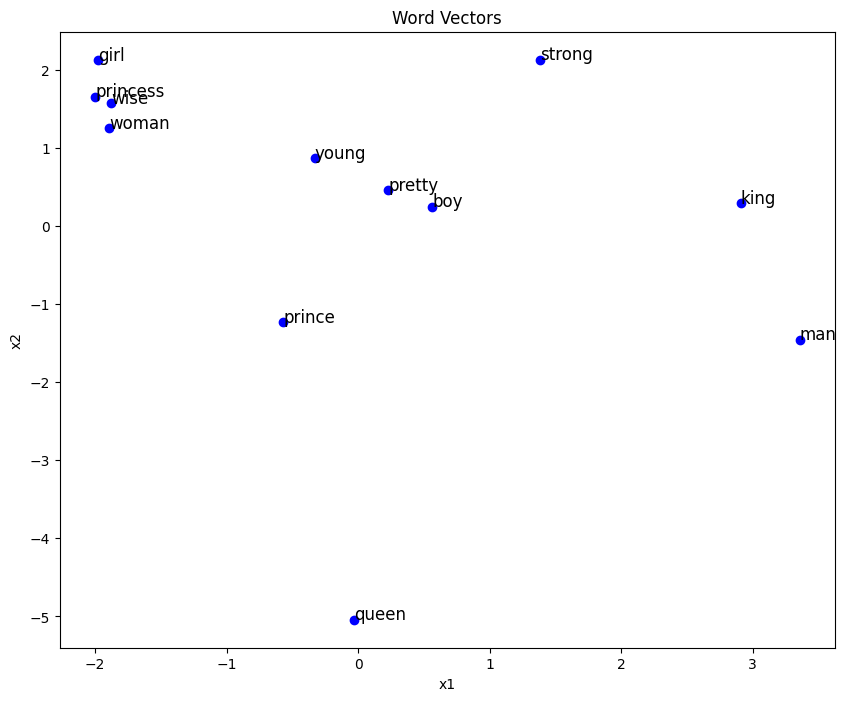

In [227]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.scatter(w2v_result['x1'], w2v_result['x2'], color='blue')

for i, word in enumerate(w2v_result['word']):
    plt.annotate(word, (w2v_result['x1'][i], w2v_result['x2'][i]), fontsize=12)

plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Word Vectors')

plt.show()
